In [1]:
from dask import delayed

In [30]:
from time import sleep

@delayed(pure=True)
def load_data(**kwargs):
    sleep(2)
    print 'load data ...'
    if kwargs:
        print kwargs
        return 'data_{}'.format(kwargs)
    return 'data'


@delayed(pure=True)
def clean_data(data):
    assert isinstance(data, str)
    print 'clean data ...'
    return 'cleaned_{}'.format(data)


@delayed(pure=True)
def analyze_data(cleaned_data, option=1, **other_options):
    assert isinstance(cleaned_data, str)
    print 'analyze data ...'
    return 'analyzed_{}'.format(cleaned_data)



First, let's define a lazy evaluation

In [31]:
data = load_data(option=100)
cleaned_data = clean_data(data)
report = analyze_data(cleaned_data)

In [50]:
from dask.delayed import to_task_dask
data2 = load_data(option=200)
task, dask = to_task_dask([report, data2])
dict(dask)

{'analyze_data-cbad2fcaa889ae9082762cb17c96196a': (<function __main__.analyze_data>,
  'clean_data-207cf24102392d8d4ae07af0ac1775e7'),
 'clean_data-207cf24102392d8d4ae07af0ac1775e7': (<function __main__.clean_data>,
  'load_data-12d583ad2ae510653086ec1950f4420f'),
 'load_data-12d583ad2ae510653086ec1950f4420f': (<function apply>,
  <function __main__.load_data>,
  [],
  (dict, [['option', 100]])),
 'load_data-834d68ef7cac96a996e2c3c66224969c': (<function apply>,
  <function __main__.load_data>,
  [],
  (dict, [['option', 200]]))}

In [59]:
report

Delayed('analyze_data-cbad2fcaa889ae9082762cb17c96196a')

We can visualize the graph of computations

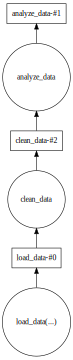

In [7]:
report.visualize(format='svg', size='5')

Let's compute the last value

In [9]:
%%time
report.compute()

CPU times: user 132 ms, sys: 34.1 ms, total: 166 ms
Wall time: 2.05 s


"analyzed_cleaned_data_{'option': 100}"

If we do it two times, the computations are again done

In [10]:
%%time
report.compute()

CPU times: user 136 ms, sys: 34.8 ms, total: 171 ms
Wall time: 2.06 s


"analyzed_cleaned_data_{'option': 100}"

Now let's persist the data, the computations are loaded.

In [11]:
report = report.persist()

Now we have immediately access to the results

In [12]:
report.compute()

"analyzed_cleaned_data_{'option': 100}"

We can see that the "report" task  has been detached from others and so, cached data are loaded when the compute method is used.

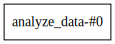

In [13]:
report.visualize(format='svg')

however, other task have not been "persisted".

In [14]:
cleaned_data.compute()

"cleaned_data_{'option': 100}"

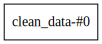

In [15]:
clean_data.visualize(format='svg', size='2')

In [16]:
cleaned_data=cleaned_data.persist()

In [47]:
cleaned_data.compute()

"cleaned_data_{'option': 100}"

Now let's look what's hapen if we make the first compuation persist only.


In [48]:
data = load_data(option=100)
cleaned_data = clean_data(data)
report = analyze_data(cleaned_data)

In [49]:
data = data.persist()

load data ...
{'option': 100}


In [51]:
data.compute()

"data_{'option': 100}"

this is not take into acount by other variables.

In [54]:
report.compute()

load data ...
{'option': 100}
clean data ...
analyze data ...


"analyzed_cleaned_data_{'option': 100}"

# With a cluster 

Let's try the same thing with a cluster

In [3]:
from distributed import LocalCluster, Client
client = Client()

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP st

In [4]:
from distributed.client import default_client
default_client()

<Client: scheduler='tcp://127.0.0.1:56119' processes=2 cores=2>

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 42] Protocol not available


In [24]:
data = load_data(option=500)
cleaned_data = clean_data(data)
report = analyze_data(cleaned_data)
#data = data.persist()
data = client.persist(data)

In [23]:
data.compute()

"data_{'option': 5000}"

In [22]:
report.compute()

"analyzed_cleaned_data_{'option': 5000}"

Now it works!

In [25]:
data = load_data(option=1000)
cleaned_data = clean_data(data)
report = analyze_data(cleaned_data)
data = data.persist()

In [26]:
#data = client.persist(data)
data.compute()

"data_{'option': 1000}"

In [27]:
report.compute()

"analyzed_cleaned_data_{'option': 1000}"

In [28]:
%%time
cleaned_data.compute()

CPU times: user 20.6 ms, sys: 4.17 ms, total: 24.8 ms
Wall time: 75.1 ms


"cleaned_data_{'option': 1000}"

In [29]:
cleaned_data.compute()

"cleaned_data_{'option': 1000}"